In [1]:
# List all file in data directory with Pathlib
import numpy as np

LABELS_DICT = {"control": 0, "sick": 1}
SUB_FOLDERS = ["control", "sick"]


# def get_mouse_model(file_path):
#     file_name = file_path.split("/")[-1]
#     if "wt" in file_name.lower():
#         return "wt"
#     elif "bin1" in file_name.lower():
#         return "bin1"
#     elif "dnm2" in file_name.lower():
#         return "dnm2"
#     else:
#         return "unknown"
#
#
# def dirty_filter_file_names(file_name):
#     file_name = file_name.split("/")[-1]
#     file_name = '_'.join(file_name.split("_")[:-1])
#     file_name = '_'.join(file_name.split("_")[1:])
#     file_name = '_'.join(file_name.split("_")[:-1])
#     file_name = ''.join(file_name.split("_SDH -")[0])
#     file_name = '_'.join(file_name.split("_")[1:])
#     return file_name

def preprocess_image(example):
    image = np.array(example['image'].resize((256, 256), reducing_gap=3.0), dtype=np.float32)
    return {"image": image, "label": example['label']}


def generate_dataset():
    n_elem = 0
    path_array = []
    mouse_model = []
    mouse_model_full = []

    myoquant_sdh_16k = datasets.load_dataset("corentinm7/MyoQuant-SDH-Data")
    for split in myoquant_sdh_16k:
        n_elem += len(myoquant_sdh_16k[split])

    images_array = np.empty(shape=(n_elem, 256, 256, 3), dtype=np.float32)
    labels_array = np.empty(shape=n_elem, dtype=np.uint8)

    counter = 0
    for split in myoquant_sdh_16k:
        for data in myoquant_sdh_16k[split]:
            processed_image = preprocess_image(data)
            # mouse_model.append(_get_mouse_model(img))
            mouse_model.append("unknown")
            # mouse_model_full.append(_dirty_filter_file_names(img))
            mouse_model_full.append("unknown")
            images_array[counter] = processed_image['image']
            labels_array[counter] = processed_image['label']
            counter += 1
    # Do it on around 13K images only because full dataset act weird somehow.
    return images_array, labels_array, mouse_model, mouse_model_full


import datasets

myoquant_sdh_16k = datasets.load_dataset("corentinm7/MyoQuant-SDH-Data")

img_data, labels, mouse_model, mouse_model_full = generate_dataset()
file_dict = dict(
    label=labels,
    image=img_data, model=mouse_model, model_full=mouse_model_full)

In [2]:
# Load image embetter 
import keras


def chunked_predict(model, X, chunk_size=1000):
    predictions = []
    for i in range(0, len(X), chunk_size):
        chunk = X[i:i + chunk_size]
        pred = model.predict(chunk, batch_size=16)
        predictions.append(pred)
    return np.vstack(predictions)


MODEL_NAME = "model.keras"
model = keras.models.load_model("model.keras")
emb_model = keras.models.Sequential()
emb_model.add(model.get_layer('sequential_1'))
emb_model.add(keras.models.Model(inputs=model.get_layer('resnet50v2').input,
                                 outputs=model.get_layer('resnet50v2').get_layer('avg_pool').output))
embeddings = chunked_predict(emb_model, file_dict["image"])
with open('image_embedding_custom.npy', 'wb') as f:
    np.save(f, embeddings)

2025-06-10 15:12:47.500135: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-06-10 15:12:47.500169: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-06-10 15:12:47.500174: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
I0000 00:00:1749561167.500498 31344102 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1749561167.500543 31344102 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-06-10 15:12:49.400981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step


In [3]:
from umap import UMAP
import numpy as np

embeddings = np.load(open('image_embedding_custom.npy', 'rb'))
embedding_umap = UMAP().fit_transform(embeddings)
embedding_umap.shape

/Users/cmeyer/code/MyoQuant-SDH-Model/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(16787, 2)

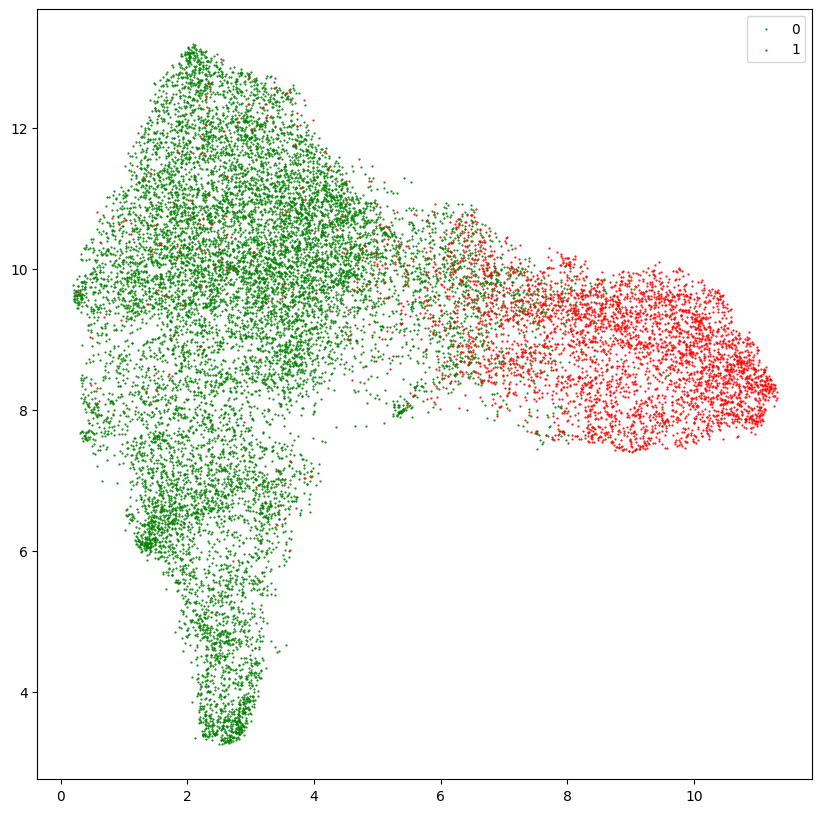

In [4]:
import matplotlib.pyplot as plt

cdict = {0: 'green', 1: 'red'}

# Get the index of row from embedding_umap where the first column is greater than 0 and the second column is greater than 0

x_condition2 = ((embedding_umap[:, 0] > 0) & (embedding_umap[:, 0] < 1))
y_condition2 = ((embedding_umap[:, 1] > 4.75) & (embedding_umap[:, 1] < 5.5))
idx_left_cluster = np.where((x_condition2 & y_condition2))[0]

x_condition = ((embedding_umap[:, 0] > 4.75) & (embedding_umap[:, 0] < 5.75))
y_condition = ((embedding_umap[:, 1] > 4.5) & (embedding_umap[:, 1] < 5.25))
idx_right_cluster = np.where((x_condition & y_condition))[0]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for g in np.unique(labels):
    ix = np.where(labels == g)
    ax.scatter(embedding_umap[:, 0][ix],
               embedding_umap[:, 1][ix],
               s=0.3,
               c=cdict[g],
               label=g)
ax.legend()
plt.show()

In [5]:
# cdict_model_full = {'BIN1_KO_AAV_EMPTY_TAG': "red",
#                     'BIN1_KO_AAV_MTM1_TAD': "blue",
#                     'BIN1_WT_AAV_EMPTY_TAG': "green",
#                     'SDH_TAM_Bin1cKO_ko_pla': "orange",
#                     'SDH_TAM_Dnm2S619L_sl_pla': "brown",
#                     'SDH_TAM_Dnm2S619L_sl_tam': "black"}
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# for g in np.unique(mouse_model_full):
#     numpy_mouse_model_full = np.array(mouse_model_full)
#     ix = np.where(numpy_mouse_model_full == g)
#     ax.scatter(embedding_umap[:, 0][ix],
#                embedding_umap[:, 1][ix],
#                s=0.3,
#                c=cdict_model_full[g],
#                label=g)
# ax.legend()
# plt.show()

In [6]:
# cdict_model = {"wt": 'green', "bin1": 'red', "dnm2": "blue", "unknown": "black"}
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# for g in np.unique(mouse_model):
#     numpy_mouse_model = np.array(mouse_model)
#     ix = np.where(numpy_mouse_model == g)
#     ax.scatter(embedding_umap[:, 0][ix],
#                embedding_umap[:, 1][ix],
#                s=0.3,
#                c=cdict_model[g],
#                label=g)
# ax.legend()
# plt.show()

In [7]:

from doubtlab.reason import ProbaReason, LongConfidenceReason, WrongPredictionReason, CleanlabReason
import pandas as pd

# Let's precalculate the proba values.
probas = chunked_predict(model, file_dict["image"])
predicted_class = np.argmax(probas, axis=1)
# We can re-use the probas below. Note that some reasons require extra information.
# Also beware that `y` and `probas` are globals now! 
predicate_dict = dict(
    proba=ProbaReason.from_proba(probas, max_proba=0.6),
    long=LongConfidenceReason.from_proba(probas, labels, classes=set(labels), threshold=0.85),
    wrong=WrongPredictionReason.from_predict(predicted_class, labels),
    cleanlab=CleanlabReason.from_proba(probas, labels),
)

# This dataframe now contains the predicates
doubtlab_df = pd.DataFrame(predicate_dict)
# Create a new column with 1 if the previous predicates are true else 0
doubtlab_df['doubt'] = doubtlab_df[["proba", "long", "wrong", "cleanlab"]].ne(0).any(axis=1)
wrong_strong_idx = doubtlab_df[doubtlab_df["long"] == 1.0].index
wrong_idx = doubtlab_df[doubtlab_df["wrong"] == 1.0].index
low_idx = doubtlab_df[doubtlab_df["proba"] == 1.0].index
cleanlab_idx = doubtlab_df[doubtlab_df["cleanlab"] == 1.0].index
doubt_idx = doubtlab_df[doubtlab_df["doubt"] == True].index
print(
    f"Total Number of images with wrong strong classficiation: {len(wrong_strong_idx)} ({round(len(wrong_strong_idx) / len(doubtlab_df) * 100, 2)}%)")
print(f"Total Number of images with wrong: {len(wrong_idx)} ({round(len(wrong_idx) / len(doubtlab_df) * 100, 2)}%)")
print(f"Total Number of images with low probas: {len(low_idx)} ({round(len(low_idx) / len(doubtlab_df) * 100, 2)}%)")
print(
    f"Total Number of images with cleanlab: {len(cleanlab_idx)} ({round(len(cleanlab_idx) / len(doubtlab_df) * 100, 2)}%)")
print(f"Total Number of doubts images: {len(doubt_idx)} ({round(len(doubt_idx) / len(doubtlab_df) * 100, 2)}%)")

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 181ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step
Total Number of images with wrong strong classficiation: 245 (1.46%)
Total Number of images with wrong: 899 (5.36%)
Total Number of images with low probas: 459 (2.73%)
Total Number of images with cleanlab: 214 (1.27%)
Total Number of doubts images: 1151 (6.86%)


Total Number of images with wrong strong classficiation: 245 (1.46%)


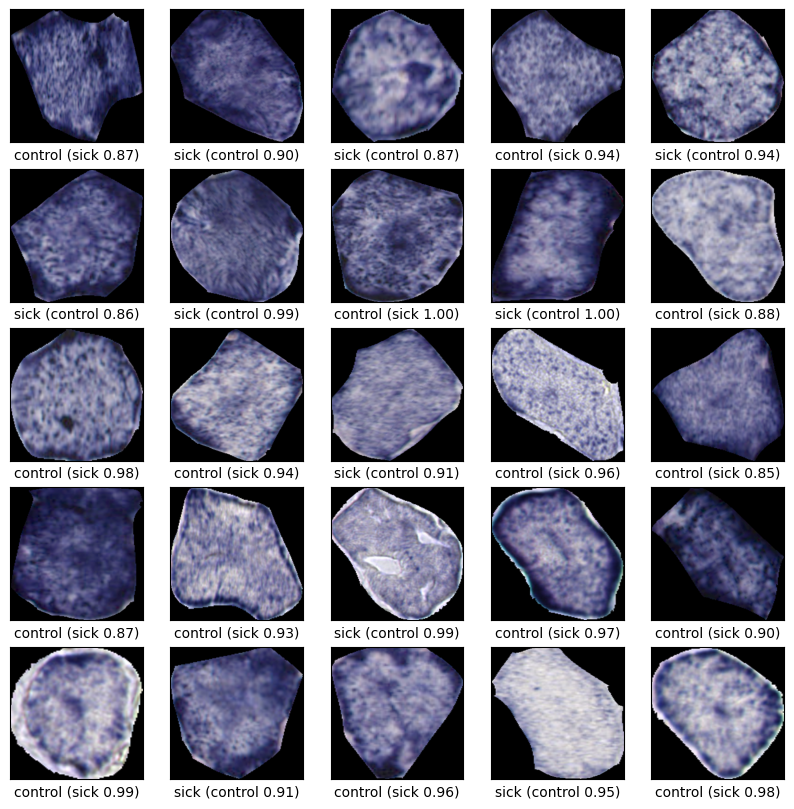

In [8]:
wrong_strong_idx = doubtlab_df[doubtlab_df["long"] == 1.0].index
print(
    f"Total Number of images with wrong strong classficiation: {len(wrong_strong_idx)} ({round(len(wrong_strong_idx) / len(doubtlab_df) * 100, 2)}%)")
SUB_FOLDERS = ["control", "sick"]
counter = 0
plt.figure(figsize=(10, 10))
for idx in np.random.choice(wrong_strong_idx, 25, replace=False):
    plt.subplot(5, 5, counter + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    im = np.asarray(img_data[idx], dtype=np.uint8)
    label = labels[idx]
    plt.imshow(im)

    predict_proba = max(probas[idx])
    predicted_class = np.argmax(probas[idx])
    plt.xlabel(f"{SUB_FOLDERS[label]} ({SUB_FOLDERS[predicted_class]} {predict_proba:.2f})")
    counter += 1
plt.show()



Total Number of images with wrong: 899 (5.36%)


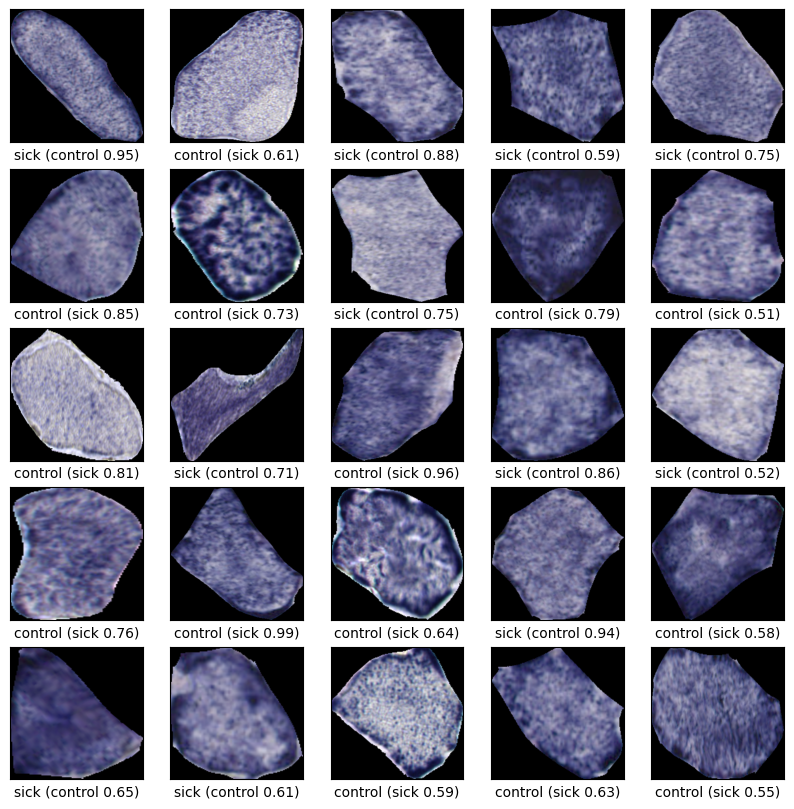

In [9]:
wrong_idx = doubtlab_df[doubtlab_df["wrong"] == 1.0].index
print(f"Total Number of images with wrong: {len(wrong_idx)} ({round(len(wrong_idx) / len(doubtlab_df) * 100, 2)}%)")
SUB_FOLDERS = ["control", "sick"]
counter = 0
plt.figure(figsize=(10, 10))
for idx in np.random.choice(wrong_idx, 25, replace=False):
    plt.subplot(5, 5, counter + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    im = np.asarray(img_data[idx], dtype=np.uint8)
    label = labels[idx]
    plt.imshow(im)

    predict_proba = max(probas[idx])
    predicted_class = np.argmax(probas[idx])
    plt.xlabel(f"{SUB_FOLDERS[label]} ({SUB_FOLDERS[predicted_class]} {predict_proba:.2f})")
    counter += 1
plt.show()



Total Number of images with low probas: 459 (2.73%)


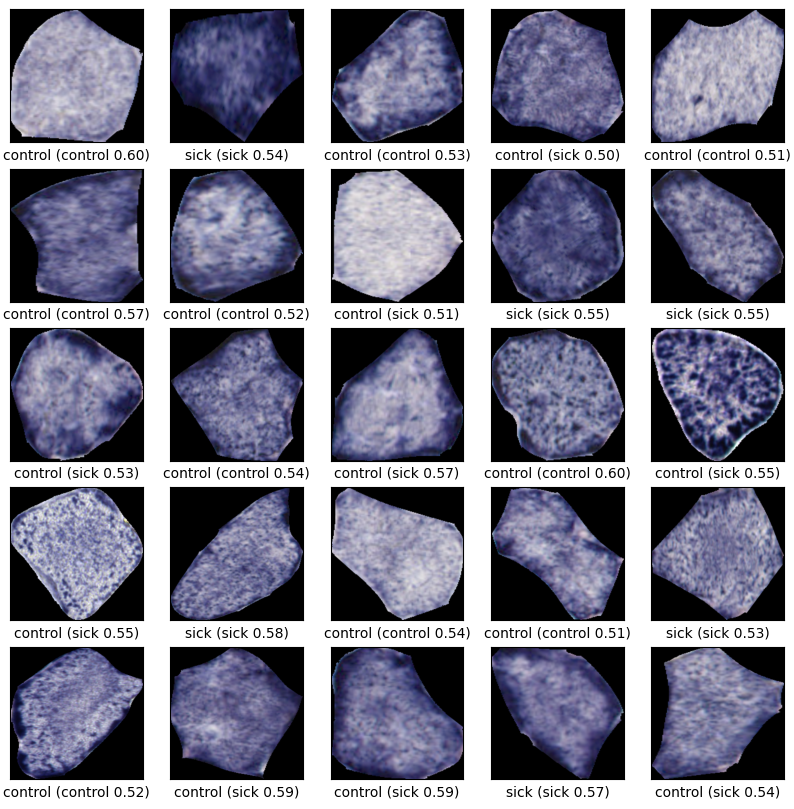

In [10]:
low_idx = doubtlab_df[doubtlab_df["proba"] == 1.0].index
print(f"Total Number of images with low probas: {len(low_idx)} ({round(len(low_idx) / len(doubtlab_df) * 100, 2)}%)")
SUB_FOLDERS = ["control", "sick"]
counter = 0
plt.figure(figsize=(10, 10))
for idx in np.random.choice(low_idx, 25, replace=False):
    plt.subplot(5, 5, counter + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    im = np.asarray(img_data[idx], dtype=np.uint8)
    label = labels[idx]
    plt.imshow(im)

    predict_proba = max(probas[idx])
    predicted_class = np.argmax(probas[idx])
    plt.xlabel(f"{SUB_FOLDERS[label]} ({SUB_FOLDERS[predicted_class]} {predict_proba:.2f})")
    counter += 1
plt.show()

Total Number of images with cleanlab: 214 (1.27%)


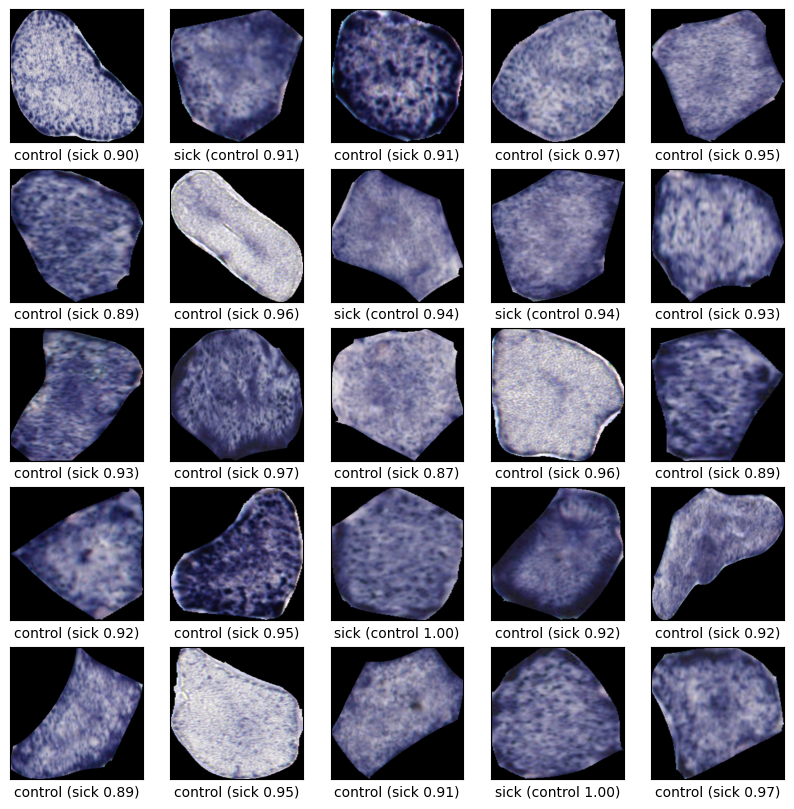

In [11]:
cleanlab_idx = doubtlab_df[doubtlab_df["cleanlab"] == 1.0].index
print(
    f"Total Number of images with cleanlab: {len(cleanlab_idx)} ({round(len(cleanlab_idx) / len(doubtlab_df) * 100, 2)}%)")
SUB_FOLDERS = ["control", "sick"]
counter = 0
plt.figure(figsize=(10, 10))
for idx in np.random.choice(cleanlab_idx, 25, replace=False):
    plt.subplot(5, 5, counter + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    im = np.asarray(img_data[idx], dtype=np.uint8)
    label = labels[idx]
    plt.imshow(im)

    predict_proba = max(probas[idx])
    predicted_class = np.argmax(probas[idx])
    plt.xlabel(f"{SUB_FOLDERS[label]} ({SUB_FOLDERS[predicted_class]} {predict_proba:.2f})")
    counter += 1
plt.show()